# RNN stock price predictor

Using Recurrent neural network (RNN) and Long short-term memory (LSTM) algorithm, one of deep learning technique, we'll predict selected ticker's future price. 

Note : This is just a basic code, hence it's not suitable to apply in real life market, and any investment should be your own decision also risk you take.





## Recurrent Neural Network (RNN)

Recurrent neural networks (RNN) are the state of the art algorithm for sequential data and are used by Apple's Siri and and Google's voice search. In RNN, neuron is called cell, information of previously trained cell is used for next cell, hence it is suitable to process sequential data.

[image : RNN]

## Long short-term memory

RNN can store short-term memory, to find correlations of data, it needs long term memory, LSTM is used to support 
this.

A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.


## Stock price predictor


### data cleansing

In [2]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
yf.pdr_override()
import matplotlib.pyplot as plt

    
def get_tickers(tickers, date_from):
    x = pdr.get_data_yahoo(tickers, start=date_from)
    df = pd.DataFrame(x[['Open', 'High', 'Low', 'Volume', 'Adj Close']])
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.rename(columns={'Adj Close' : 'Close'}, inplace=True)
    return df

def Normalizer(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data, 0) - np.min(data,0)
    return numerator / (denominator + 1e-7)

In [3]:
tickers = ['SPLG']
df = get_tickers(tickers, '2017-10-17')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Volume,Close
Date,,,,,
2017-10-16,30.010000,30.010000,29.940001,8800,27.997444
2017-10-17,29.950001,30.049999,29.920000,21500,27.960064
2017-10-18,30.129999,30.129999,29.990000,49200,28.044165
2017-10-19,29.990000,30.000000,29.850000,24300,28.034821
2017-10-20,30.100000,30.219999,30.090000,164900,28.174995
...,...,...,...,...,...
2021-05-27,49.410000,49.459999,49.279999,1314000,49.299999
2021-05-28,49.500000,49.529999,49.360001,1939100,49.369999
2021-06-01,49.689999,49.689999,49.290001,1899600,49.349998


In [4]:
dfx = Normalizer(df)
dfy = dfx[['Close']]


x = dfx.values.tolist()
y = dfy.values.tolist()

In [5]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 914 entries, 2017-10-16 to 2021-06-03
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    914 non-null    float64
 1   High    914 non-null    float64
 2   Low     914 non-null    float64
 3   Volume  914 non-null    float64
 4   Close   914 non-null    float64
dtypes: float64(5)
memory usage: 42.8 KB


In [6]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 914 entries, 2017-10-16 to 2021-06-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   914 non-null    float64
dtypes: float64(1)
memory usage: 14.3 KB


In [7]:
data_x = []
data_y = []
window_size = 10
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # not including next day close (i+window_size)
    _y = y[i + window_size] # Next day close
    data_x.append(_x)
    data_y.append(_y)

Run `print(_x, "->", _y)` to see _x values added to data_x and _y

In [8]:
print(_x, "->", _y)

[[0.9195452413433595, 0.93950033407811, 0.9279697054020196, 0.16325182271829805, 0.9456189211249919], [0.9449060570673157, 0.9679965078418374, 0.9595619549416855, 0.0744438571672856, 0.9669531369250419], [0.9711412341342055, 0.9758877971272848, 0.9734624611821634, 0.08855923640151069, 0.9648614282417274], [0.9728902904184482, 0.9872862331851884, 0.9865206488390285, 0.0464423958835324, 0.9853589924834453], [0.9886314633782572, 0.9890398901903849, 0.9894692459411447, 0.07700887652152254, 0.9815941402584346], [0.9811980575698195, 0.9837790864127323, 0.9898904052329511, 0.04430876614796258, 0.9857772384751272], [0.9877569352361358, 0.9890398901903849, 0.9966300787072868, 0.05072520092651588, 0.9866138900334595], [0.9916922284760881, 0.9921087063305104, 0.9999999957877, 0.07501904332550843, 0.989542090700138], [0.9999999956274593, 0.9991231671133596, 0.9970513986855838, 0.07348391810592723, 0.9887054391418058], [0.9886314633782572, 0.9916703756981796, 0.9974725579773901, 0.05128095511993388

Past 10 days, given data, latest close is 0.8726370803053053, next day close is 0.8677396475977315

### Prepare train / test dataset

In [9]:
# train dataset
train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

# test dataset
test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

### Build model

In [19]:
# model = keras.Sequential()
# model.add(layers.LSTM(units=10, activation='relu',
#                       return_sequences=True, input_shape=(window_size, 5)))
# model.add(layers.Dropout(0.1))
# model.add(layers.LSTM(units=10, activation='relu'))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(units=1))
# model.summary()

from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation
model = keras.Sequential()
model.add(layers.LSTM(units=30, activation='relu',
                      return_sequences=True, input_shape=(window_size, 5)))
model.add(layers.Dropout(0.1))
model.add(layers.LSTM(units=40, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=60, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(units=90, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 30)            4320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 40)            11360     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 60)            24240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 90)               

### Model fit

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=20, batch_size=30)
pred_y = model.predict(test_x)

Epoch 1/20
22/22 [==============================] - 5s 99ms/step - loss: 0.0527
Epoch 2/20
22/22 [==============================] - 2s 99ms/step - loss: 0.0113
Epoch 3/20
22/22 [==============================] - 2s 99ms/step - loss: 0.0080
Epoch 4/20
22/22 [==============================] - 2s 99ms/step - loss: 0.0045
Epoch 5/20
22/22 [==============================] - 2s 102ms/step - loss: 0.0042
Epoch 6/20
22/22 [==============================] - 2s 106ms/step - loss: 0.0045
Epoch 7/20
22/22 [==============================] - 2s 99ms/step - loss: 0.0041
Epoch 8/20
22/22 [==============================] - 2s 97ms/step - loss: 0.0040
Epoch 9/20
22/22 [==============================] - 2s 99ms/step - loss: 0.0035
Epoch 10/20
22/22 [==============================] - 2s 98ms/step - loss: 0.0038
Epoch 11/20
22/22 [==============================] - 2s 100ms/step - loss: 0.0030
Epoch 12/20
22/22 [==============================] - 2s 103ms/step - loss: 0.0033
Epoch 13/20
22/22 [==============

### Compare prediction to real

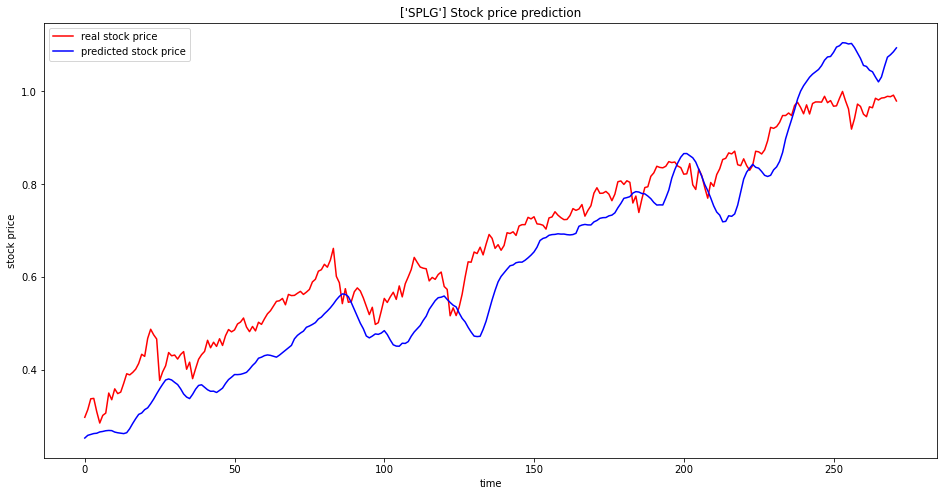

In [21]:
plt.figure(figsize=(16,8))
plt.plot(test_y, c='r', label='real stock price')
plt.plot(pred_y, c='blue', label='predicted stock price')
plt.title(f'{tickers} Stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

### Predict tomorrw's close price

In [22]:
print(f'{tickers} tomorrow price : {df.Close[-1]*pred_y[-1]/dfy.Close[-1]}')

['SPLG'] tomorrow price : [54.87004]
